In [19]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageChops, ImageEnhance

In [20]:
def gaussian_blur_difference(image):
    """Apply Gaussian blur and compute absolute difference."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    diff = cv2.absdiff(gray, blurred)
    return cv2.cvtColor(diff, cv2.COLOR_GRAY2BGR)

def error_level_analysis(image, quality=95):
    """Perform Error Level Analysis (ELA) on an image."""
    try:
        im = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        temp_compressed = "temp_compressed.jpg"
        im.save(temp_compressed, "JPEG", quality=quality)
        compressed = Image.open(temp_compressed)
        ela_image = ImageChops.difference(im, compressed)
        ela_image = ImageEnhance.Brightness(ela_image).enhance(5)
        os.remove(temp_compressed)
        return cv2.cvtColor(np.array(ela_image), cv2.COLOR_RGB2BGR)
    except Exception as e:
        print(f"ELA Error: {e}")
        return None

def preprocess_image(image, image_size=(128, 128)):
    """Apply Gaussian Blur Difference and Error Level Analysis."""
    gb_diff = gaussian_blur_difference(image)
    ela_image = error_level_analysis(image)
    if ela_image is None:
        return None
    gb_resized = cv2.resize(gb_diff, image_size)
    ela_resized = cv2.resize(ela_image, image_size)
    return cv2.addWeighted(gb_resized, 0.2, ela_resized, 0.8, 0)

In [21]:
def prepare_dataset(dataset_path, image_size=(128, 128), data_limit=None):
    """Load and preprocess images, returning feature matrix X and labels y."""
    X, y = [], []
    for class_name in ["Au", "Tp"]:
        class_path = os.path.join(dataset_path, class_name)
        label = 0 if class_name == "Au" else 1
        data_list = (
            os.listdir(class_path)[0:data_limit]
            if data_limit
            else os.listdir(class_path)
        )
        for img_file in data_list:
            if img_file.lower().endswith(
                (".png", ".jpg", ".jpeg", ".tif", ".tiff", ".bmp")
            ):
                img = cv2.imread(os.path.join(class_path, img_file))
                processed_img = preprocess_image(img, image_size)
                if processed_img is not None:
                    X.append(processed_img)
                    y.append(label)
    return np.array(X), np.array(y)

In [22]:
from tensorflow.keras import regularizers

# def build_model():
#     model = models.Sequential([
#         layers.Conv2D(32, (3, 3), strides=1, activation='relu', input_shape=(224, 224, 3)),
#         layers.MaxPooling2D((2, 2)),
#         layers.Conv2D(32, (3, 3), strides=1, activation='relu'),
#         layers.MaxPooling2D((2, 2)),
#         layers.Flatten(),
#         layers.Dense(64, activation='relu'),
#         layers.Dropout(0.5),
#         layers.Dense(1, activation='sigmoid')  # Binary classification
#     ])
    
#     # Compile with accuracy and AUC as metrics
#     model.compile(optimizer='adam', 
#                   loss='binary_crossentropy', 
#                   metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    
    
#     return model




def build_model( num_classes=2):
    model = models.Sequential([
        layers.Conv2D(32, (5, 5), strides=1, activation='relu', input_shape=(128, 128, 3)),
        layers.Conv2D(32, (5, 5), strides=1, activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    # Compile with accuracy and AUC as metrics
    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [36]:
# def train_model(model, X, y, epochs=12):
#     """Train the model with optimized parameters and class weighting."""
#     X_train, X_test, y_train, y_test = train_test_split(
#         X, y, test_size=0.2, stratify=y, random_state=42
#     )
#     print(X_train.shape, y_train.shape)

#     X_test, X_val, y_test, y_val = train_test_split(
#         X_test, y_test, test_size=0.5, stratify=y_test, random_state=42
#     )
#     print(X_test.shape, y_test.shape)
#     print(X_val.shape, y_val.shape)

#     history = model.fit(
#         X_train,
#         y_train,
#         validation_data=(X_val, y_val),
#         epochs=epochs,

#     )
#     return model, history, X_test, y_test


from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

def train_model(model, X, y, epochs=12):
    """Train the model with optimized parameters and class weighting."""

    # One-hot encode the labels
    y = to_categorical(y, num_classes=2)

    # Train/val/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y.argmax(axis=1), random_state=42
    )
    print(X_train.shape, y_train.shape)

    X_test, X_val, y_test, y_val = train_test_split(
        X_test, y_test, test_size=0.5, stratify=y_test.argmax(axis=1), random_state=42
    )
    print(X_test.shape, y_test.shape)
    print(X_val.shape, y_val.shape)

    # Normalize pixel values
    X_train = X_train.astype("float32") / 255.0
    X_val = X_val.astype("float32") / 255.0
    X_test = X_test.astype("float32") / 255.0

    # Train the model
    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
    )
    return model, history, X_test, y_test


In [37]:
# def evaluate_model(model, X_test, y_test):
#     """Evaluate the model on the test set and generate various plots."""
#     test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
#     y_pred_proba = model.predict(X_test)
#     y_pred = (y_pred_proba > 0.5).astype(int).flatten()

#     print("\nTest Metrics:")
#     print(classification_report(y_test, y_pred))

#     # Confusion Matrix
#     cm = confusion_matrix(y_test, y_pred)
#     plt.figure(figsize=(8, 6))
#     sns.heatmap(
#         cm,
#         annot=True,
#         fmt="d",
#         cmap="Blues",
#         xticklabels=["Non-Forged", "Forged"],
#         yticklabels=["Non-Forged", "Forged"],
#     )
#     plt.title("Confusion Matrix")
#     plt.xlabel("Predicted")
#     plt.ylabel("Actual")
#     plt.show()

#     # ROC Curve
#     fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
#     plt.figure()
#     # plt.plot(fpr, tpr, label=f"ROC curve (AUC = {test_auc:.2f})")
#     plt.plot([0, 1], [0, 1], "k--")
#     plt.xlabel("False Positive Rate")
#     plt.ylabel("True Positive Rate")
#     plt.legend()
#     plt.show()

#     # Precision-Recall Curve
#     precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
#     plt.figure()
#     plt.plot(recall, precision, label="Precision-Recall Curve")
#     plt.xlabel("Recall")
#     plt.ylabel("Precision")
#     plt.legend()
#     plt.show()
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    precision_recall_curve
)
import numpy as np

def evaluate_model(model, X_test, y_test):
    """Evaluate the model on the test set and generate plots."""
    
    # Step 1: Evaluate and unpack loss and accuracy
    results = model.evaluate(X_test, y_test, verbose=1)
    test_loss = results[0]
    test_accuracy = results[1] if len(results) > 1 else None
    
    print("\n📊 Evaluation Results:")
    print(f"Loss:     {test_loss:.4f}")
    if test_accuracy is not None:
        print(f"Accuracy: {test_accuracy:.4f}")
    
    # Step 2: Predict
    y_pred_proba = model.predict(X_test)
    if y_pred_proba.shape[1] == 1:
        y_pred = (y_pred_proba > 0.5).astype(int).flatten()
        y_test_labels = y_test.flatten()
        y_pred_scores = y_pred_proba.flatten()
    else:
        y_pred = np.argmax(y_pred_proba, axis=1)
        y_test_labels = np.argmax(y_test, axis=1)
        y_pred_scores = y_pred_proba[:, 1] if y_pred_proba.shape[1] > 1 else y_pred_proba[:, 0]

    # Step 3: Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test_labels, y_pred))

    # Step 4: Confusion Matrix
    cm = confusion_matrix(y_test_labels, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Non-Forged", "Forged"],
        yticklabels=["Non-Forged", "Forged"],
    )
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Step 5: ROC Curve
    fpr, tpr, _ = roc_curve(y_test_labels, y_pred_scores)
    plt.figure()
    plt.plot(fpr, tpr, label="ROC Curve")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid()
    plt.show()

    # Step 6: Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test_labels, y_pred_scores)
    plt.figure()
    plt.plot(recall, precision, label="Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.grid()
    plt.show()


In [32]:
# Step 1: Build model
image_size = (128, 128)
model = build_model()
model.summary()


/Users/logpoint/Documents/SoftwareProjects/Thesis/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 124, 124, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 120, 120, 32)   │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 60, 60, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 60, 60, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,774,050 (56.36 MB)

 Trainable params: 14,774,050 (56.36 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
# Step 2: Define dataset path and image size
dataset_path = r"./CASIA22"

# Step 3: Prepare dataset
X, y = prepare_dataset(dataset_path, image_size)

In [34]:
# Step 4: Train model
model, history, X_test, y_test = train_model(model, X, y, epochs=12)


(10091, 128, 128, 3) (10091, 2)
(1261, 128, 128, 3) (1261, 2)
(1262, 128, 128, 3) (1262, 2)
Epoch 1/12
316/316 ━━━━━━━━━━━━━━━━━━━━ 317s 1s/step - accuracy: 0.6747 - loss: 0.6294 - val_accuracy: 0.8122 - val_loss: 0.4660
Epoch 2/12
316/316 ━━━━━━━━━━━━━━━━━━━━ 315s 996ms/step - accuracy: 0.7916 - loss: 0.4737 - val_accuracy: 0.8082 - val_loss: 0.4613
Epoch 3/12
316/316 ━━━━━━━━━━━━━━━━━━━━ 315s 998ms/step - accuracy: 0.8439 - loss: 0.3720 - val_accuracy: 0.8249 - val_loss: 0.4123
Epoch 4/12
316/316 ━━━━━━━━━━━━━━━━━━━━ 321s 1s/step - accuracy: 0.8800 - loss: 0.2877 - val_accuracy: 0.8764 - val_loss: 0.2849
Epoch 5/12
316/316 ━━━━━━━━━━━━━━━━━━━━ 314s 994ms/step - accuracy: 0.9038 - loss: 0.2160 - val_accuracy: 0.8875 - val_loss: 0.2557
Epoch 6/12
316/316 ━━━━━━━━━━━━━━━━━━━━ 320s 1s/step - accuracy: 0.9273 - loss: 0.1690 - val_accuracy: 0.8883 - val_loss: 0.2514
Epoch 7/12
316/316 ━━━━━━━━━━━━━━━━━━━━ 318s 1s/step - accuracy: 0.9411 - loss: 0.1296 - val_accuracy: 0.8994 - val_loss: 0.2

40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 223ms/step - accuracy: 0.8746 - loss: 0.5256

📊 Evaluation Results:
Loss:     0.4861
Accuracy: 0.8826
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 219ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.88      0.90       749
           1       0.84      0.88      0.86       512

    accuracy                           0.88      1261
   macro avg       0.88      0.88      0.88      1261
weighted avg       0.88      0.88      0.88      1261



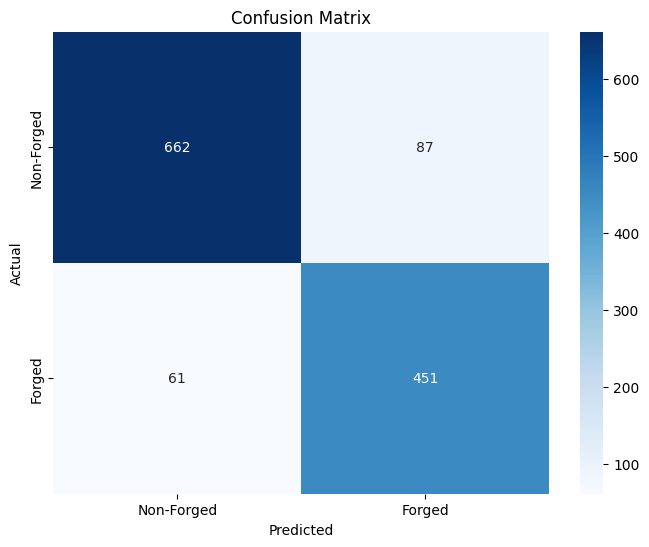

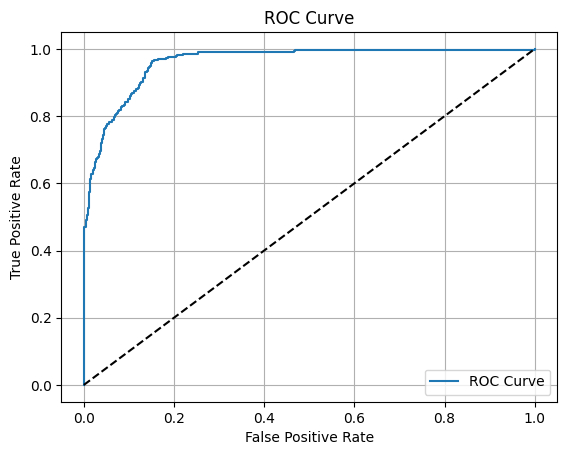

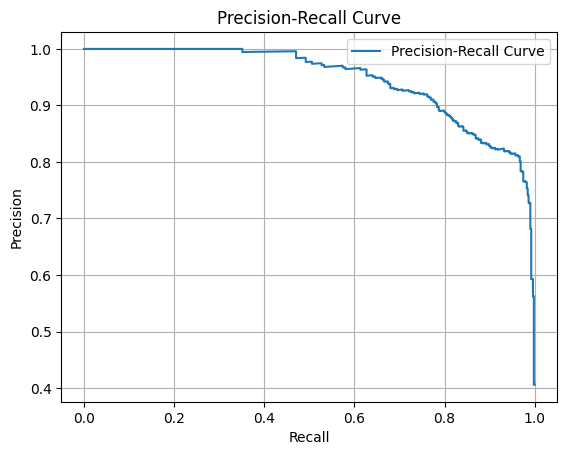

In [38]:

# Step 5: Evaluate model
evaluate_model(model, X_test, y_test)

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


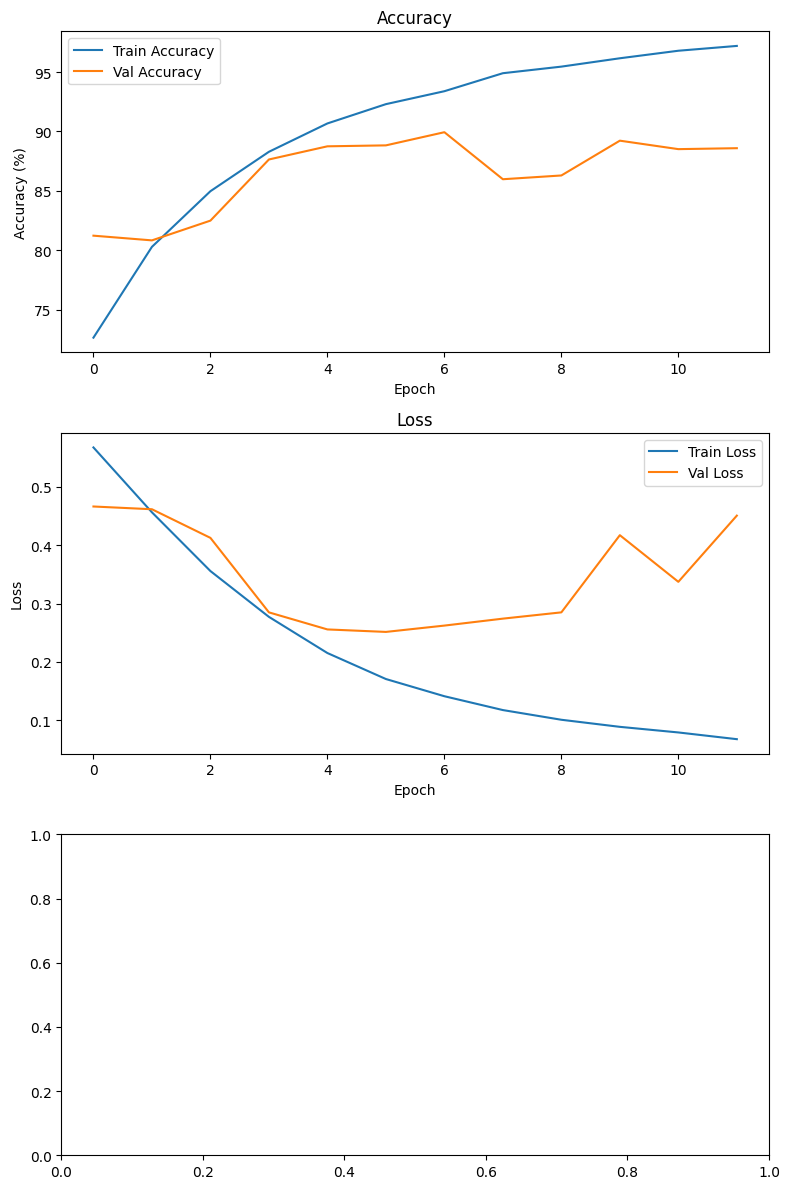

In [40]:
def plot_training_curves(history):
    """Plot training history including loss, accuracy, and AUC on a 0-100% scale."""
    print(history.history.keys())

    fig, ax = plt.subplots(3, 1, figsize=(8, 12))  # 3 rows, 1 column, taller figure

    # Accuracy (Scaled to 0-100%)
    ax[0].plot(np.array(history.history['accuracy']) * 100, label='Train Accuracy')
    ax[0].plot(np.array(history.history['val_accuracy']) * 100, label='Val Accuracy')
    ax[0].set_title('Accuracy')
    ax[0].set_ylabel('Accuracy (%)')
    ax[0].set_xlabel('Epoch')
    # ax[0].set_ylim(70, 110)
    ax[0].legend()

    # Loss (Keep original scale)
    ax[1].plot(np.array(history.history['loss']), label='Train Loss')
    ax[1].plot(np.array(history.history['val_loss']), label='Val Loss')
    ax[1].set_title('Loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    # ax[1].set_ylim(0, 30)
    ax[1].legend()

    # AUC (Scaled to 0-100%)
    # ax[2].plot(np.array(history.history['auc']) * 100, label='Train AUC')
    # ax[2].plot(np.array(history.history['val_auc']) * 100, label='Val AUC')
    # ax[2].set_title('AUC Score')
    # ax[2].set_ylabel('AUC (%)')
    # ax[2].set_xlabel('Epoch')
    # # ax[2].set_ylim(80, 110)
    # ax[2].legend()

    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()
# Step 6: Plot training curves
plot_training_curves(history)